---

In [1]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("/home/twhit/smc_object_detection/")
from utils.misc import select_cuda_device

device = select_cuda_device(min_free_mb=1000)

Selected device 2, which has 10820 MB available.


In [2]:
tile_dim = 8
pad = 2

num_batches = len(glob.glob("smc/counts_*.pt"))
batch_size = 10
num_images = num_batches * batch_size

prior_max_objects = 6
num_catalogs_per_count = 10000
num_catalogs = num_catalogs_per_count * (prior_max_objects + 1)

images = torch.load('../data/tiles.pt')[:num_images]
pruned_counts = torch.load('../data/counts_magcut.pt')[:num_images]
pruned_locs = torch.load('../data/locs_magcut.pt')[:num_images]
pruned_fluxes = torch.load('../data/fluxes_magcut.pt')[:num_images]

smc_unpruned_counts = torch.zeros([num_batches, batch_size, num_catalogs])
smc_unpruned_locs = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects, 2])
smc_unpruned_fluxes = torch.zeros([num_batches, batch_size, num_catalogs, prior_max_objects])
smc_posterior_predictive_total_flux = torch.zeros([num_batches, batch_size, num_catalogs])
smc_runtime = torch.zeros([num_batches, batch_size])
smc_num_iters = torch.zeros([num_batches, batch_size])

for b in range(num_batches):
    smc_unpruned_counts[b] = torch.load(f'smc/counts_{b}.pt')
    smc_unpruned_locs[b] = torch.load(f'smc/locs_{b}.pt')
    smc_unpruned_fluxes[b] = torch.load(f'smc/fluxes_{b}.pt')
    smc_posterior_predictive_total_flux[b] = torch.load(f'smc/posterior_predictive_total_flux_{b}.pt')
    smc_runtime[b] = torch.load(f'smc/runtime_{b}.pt')
    smc_num_iters[b] = torch.load(f'smc/num_iters_{b}.pt')

smc_unpruned_counts = smc_unpruned_counts.flatten(0,1)
smc_unpruned_locs = smc_unpruned_locs.flatten(0,1)
smc_unpruned_fluxes = smc_unpruned_fluxes.flatten(0,1)
smc_posterior_predictive_total_flux = smc_posterior_predictive_total_flux.flatten(0,1)
smc_runtime = smc_runtime.flatten(0,1)
smc_num_iters = smc_num_iters.flatten(0,1)

In [3]:
smc_mask = torch.logical_and(smc_unpruned_locs > 0, smc_unpruned_locs < tile_dim).all(-1)
smc_pruned_counts = smc_mask.sum(-1)

smc_pruned_locs = smc_mask.unsqueeze(-1) * smc_unpruned_locs
smc_locs_mask = (smc_pruned_locs != 0).int()
smc_locs_index = torch.sort(smc_locs_mask, dim=-2, descending=True)[1]
smc_pruned_locs = torch.gather(smc_pruned_locs, dim=-2, index=smc_locs_index)

smc_pruned_fluxes = smc_mask * smc_unpruned_fluxes
smc_fluxes_mask = (smc_pruned_fluxes != 0).int()
smc_fluxes_index = torch.sort(smc_fluxes_mask, dim=-1, descending=True)[1]
smc_pruned_fluxes = torch.gather(smc_pruned_fluxes, dim=-1, index=smc_fluxes_index)

---

In [4]:
from einops import rearrange
from bliss.catalog import convert_nmgy_to_mag
from scipy.optimize import linear_sum_assignment

In [5]:
locs_thresh = 0.5
mags_thresh = 0.5

In [6]:
num_tiles = images.shape[0]
num_catalogs_per_tile = 500

In [7]:
pruned_counts = pruned_counts.int()
smc_pruned_counts = smc_pruned_counts.int()

In [8]:
mag_filters = torch.arange(18, 25, step = 0.5)

tp = torch.zeros(num_tiles, num_catalogs_per_tile, len(mag_filters))
fp = torch.zeros(num_tiles, num_catalogs_per_tile, len(mag_filters))
fn = torch.zeros(num_tiles, num_catalogs_per_tile, len(mag_filters))

for t in range(num_tiles):
    true_locs = pruned_locs[t][:pruned_counts[t]]
    true_mags = convert_nmgy_to_mag(pruned_fluxes[t][:pruned_counts[t]])

    catalog_indexes = torch.randint(0, smc_pruned_counts.shape[-1], size = [num_catalogs_per_tile])

    for n in range(num_catalogs_per_tile):
        est_locs = smc_pruned_locs[t][catalog_indexes[n]][:smc_pruned_counts[t][catalog_indexes[n]].int()]

        locs_diff = rearrange(true_locs, "i j -> i 1 j") - rearrange(est_locs, "i j -> 1 i j")
        locs_dist = locs_diff.norm(dim=-1)
        oob = locs_dist > locs_thresh

        est_mags = convert_nmgy_to_mag(smc_pruned_fluxes[t][catalog_indexes[n]][:smc_pruned_counts[t][catalog_indexes[n]].int()])
        mags_dist = (rearrange(true_mags, "k -> k 1") - rearrange(est_mags, "k -> 1 k")).abs()
        oob |= mags_dist > mags_thresh

        cost = locs_dist + oob * 1e20
        row_indx, col_indx = linear_sum_assignment(cost)
        matches = ~oob[row_indx, col_indx].numpy()

        assert row_indx[matches].shape[0] == col_indx[matches].shape[0]
        true_matches = torch.from_numpy(row_indx[matches])
        est_matches = torch.from_numpy(col_indx[matches])
        
        true_mags_bucketed = torch.bucketize(true_mags, mag_filters).unsqueeze(-1) == torch.arange(len(mag_filters))
        est_mags_bucketed = torch.bucketize(est_mags, mag_filters).unsqueeze(-1) == torch.arange(len(mag_filters))

        tp[t,n] = true_mags_bucketed[true_matches].sum(0)
        fn[t,n] = true_mags_bucketed.sum(0) - tp[t,n]
        fp[t,n] = est_mags_bucketed.sum(0) - tp[t,n]

In [9]:
precision = (tp.sum(0) / (tp + fp).sum(0)).mean(0)
recall = (tp.sum(0) / (tp + fn).sum(0)).mean(0)
f1 = (2 * precision * recall) / (precision + recall)

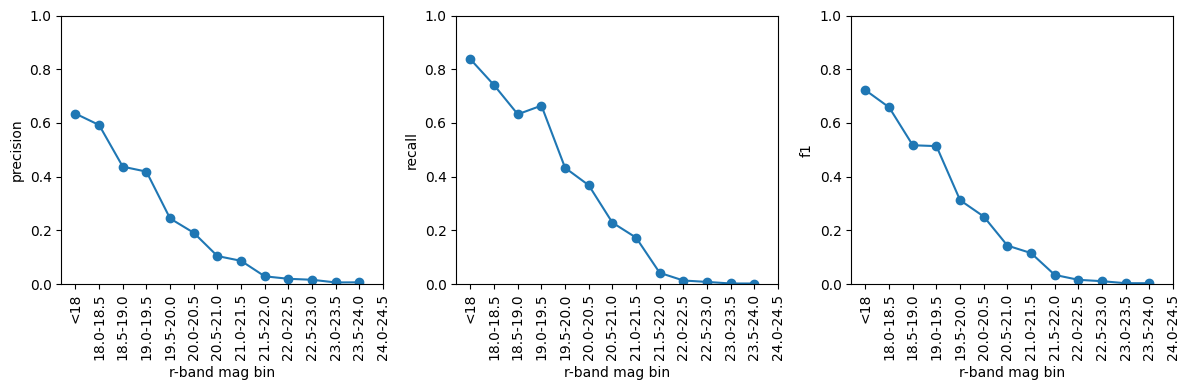

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

_ = ax[0].plot(mag_filters, precision, "o-")
_ = ax[0].set_ylabel('precision')
_ = ax[1].plot(mag_filters, recall, "o-")
_ = ax[1].set_ylabel('recall')
_ = ax[2].plot(mag_filters, f1, "o-")
_ = ax[2].set_ylabel('f1')

for a in ax.flat:
    _ = a.set_xticks(ticks = mag_filters,
                   labels = ['<18'] + [f'{mag_filters[t].item()}-{mag_filters[t+1]}' for t in range(len(mag_filters)-1)],
                   rotation = 90)
    _ = a.set_ylim(0,1)
    _ = a.set_xlabel('r-band mag bin')

_ = fig.tight_layout()